## PROJECT 22: What's Cooking?

> ### TASK: Use recipe ingredients to categorize the cuisine with Natural Language Processing 

### Project goals and objectives

#### Project goal

- Studying **Convolutional Neural Networks for NPL**

#### Project objectives

1. Explore and prepare data 
2. Training several 1D CNN

#### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
tqdm.pandas()

import re
import unidecode

from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Dropout, Dense,GlobalAveragePooling1D, Input, Embedding, MaxPool1D, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import pydot
import graphviz

#### Load data

In [2]:
# Path to data
train_data_path = "data/train.json"
test_data_path = "data/test.json"

In [3]:
# Create dataframe
train_df = pd.read_json(train_data_path)
test_df = pd.read_json(test_data_path)

In [4]:
train_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
test_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [6]:
print(f"Total training samples: {len(train_df)}, traing shape: {train_df.shape}")
print(f"Total test samples: {len(test_df)}, test shape: {test_df.shape}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 39774, traing shape: (39774, 3)
Total test samples: 9944, test shape: (9944, 2)
Total samples: 49718


In [7]:
train_df.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

## EXPLORATORY DATA ANALISIS

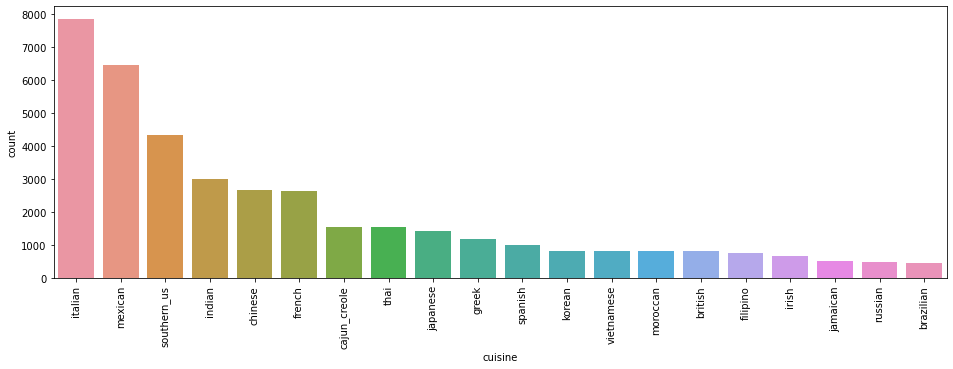

In [8]:
plt.figure(figsize=(16,5))
plt.xticks(rotation=90)
ax= sns.countplot(x='cuisine', data= train_df, order = train_df['cuisine'].value_counts().index)

In [9]:
print('Cuisines count: ',len(train_df['cuisine'].unique()))

num_cuisines = len(train_df['cuisine'].unique())

Cuisines count:  20


### Maximum and minimum number of ingredients in recipes

In [10]:
print('Maximum Number of Ingredients in a recipe: ',train_df['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a recipe: ',train_df['ingredients'].str.len().min())

Maximum Number of Ingredients in a recipe:  65
Minimum Number of Ingredients in a recipe:  1


#### Create a feature that stores number of ingredients

In [11]:
#No of Ingredients
train_df['ing_count'] = train_df['ingredients'].str.len()
train_df['ing_count']

0         9
1        11
2        12
3         4
4        20
         ..
39769    12
39770     7
39771    12
39772    21
39773    12
Name: ing_count, Length: 39774, dtype: int64

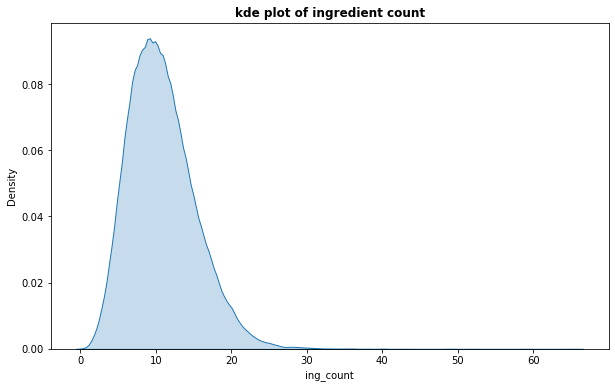

In [12]:
#Distribution of number of ingredients
plt.figure(figsize=(10,6))
sns.kdeplot(data=train_df["ing_count"], shade=True)
plt.title('kde plot of ingredient count',fontweight="bold")
plt.show()

<AxesSubplot:xlabel='ing_count', ylabel='count'>

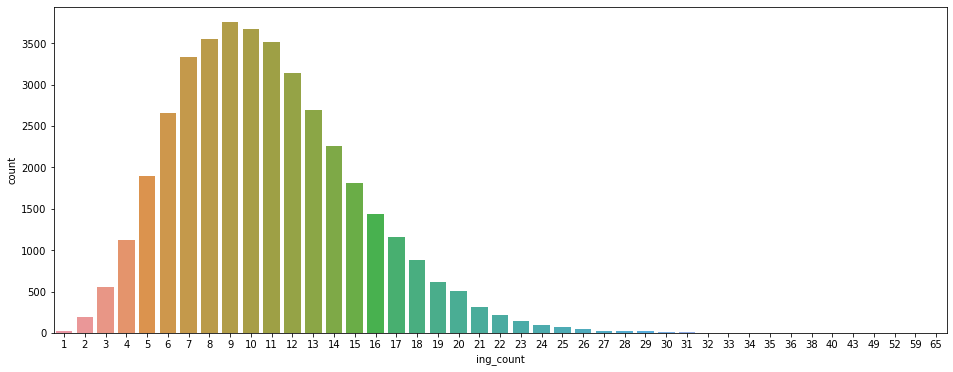

In [13]:
plt.figure(figsize=(16,6))
sns.countplot(x='ing_count', data= train_df)

In [14]:
# Recipes with lots of ingredients
train_df[train_df['ing_count'] >= 40]

,id,cuisine,ingredients,ing_count
345,45039,thai,"[fish sauce, hot red pepper flakes, cider vine...",40
3359,21624,indian,"[red chili peppers, fresh coriander, fresh gin...",40
6449,6548,southern_us,"[canned black beans, seasoned bread crumbs, pr...",40
10513,49282,mexican,"[condensed cream of chicken soup, pepper, refr...",49
15289,3885,italian,"[fettucine, fresh marjoram, minced garlic, oli...",65
22906,2253,indian,"[white vinegar, sparkling lemonade, coconut su...",49
26103,13049,mexican,"[vanilla ice cream, lime, garlic powder, zucch...",52
30350,13430,brazilian,"[marshmallows, fresh corn, cheddar cheese, shr...",59
31250,29216,italian,"[eggs, warm water, pepper, dried basil, unsalt...",43


In [15]:
# One Ingredient Recipes
train_df[train_df['ing_count'] <= 1]

,id,cuisine,ingredients,ing_count
940,4734,japanese,[sushi rice],1
2088,7833,vietnamese,[dried rice noodles],1
6787,36818,indian,[plain low-fat yogurt],1
7011,19772,indian,[unsalted butter],1
8181,16116,japanese,[udon],1
8852,29738,thai,[sticky rice],1
8990,41124,indian,[butter],1
10506,32631,mexican,[corn tortillas],1
13178,29570,thai,[grained],1
17804,29849,southern_us,[lemonade concentrate],1


### Most common ingredient

In [16]:
# Taking Out all the ingredients in the dataset and storing in a list
ingredients_list = [ing for ingredients in train_df['ingredients'] for ing in ingredients]

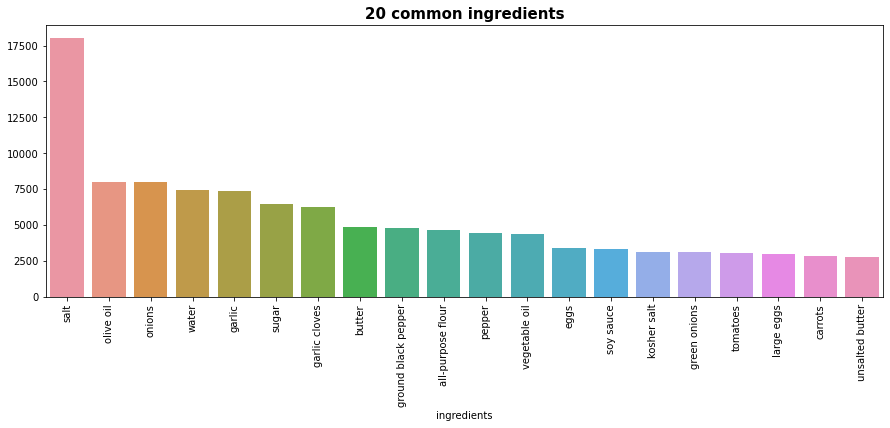

In [17]:
ingredients_count = pd.Series(dict(Counter(','.join(ingredients_list).split(',')))).sort_values(ascending=False)
top20ingredients = ingredients_count.head(20)

plt.figure(figsize=(15,5))
sns.barplot(x= top20ingredients.index, y=top20ingredients)
plt.xticks(rotation=90)
plt.title('20 common ingredients', fontsize=15, fontweight='bold')
plt.xlabel('ingredients')
plt.show()

## DATA PREPROCESSING

In [18]:
# Remove outliers
train_df = train_df[train_df['ing_count'] > 1]
train_df = train_df[train_df['ing_count']<60]

In [19]:
# Basic cleaning
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients = ' '.join(ingredients)
    ingredients = ingredients.lower() #Convert to lowercase
    ingredients = re.sub('[,\.!?:()"]', '',ingredients) # remove punctuation marks 
    ingredients = re.sub('[^a-zA-Z"]',' ',ingredients) # remove all strings that contain a non-letter
    ingredients = ingredients.replace('-', ' ')
    words = []
    for word in ingredients.split():
        word = re.sub("[0-9]"," ",word) #removing numbers
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', word) # Removing Units
        if len(word) <= 2: continue
        word = unidecode.unidecode(word)
        word = lemmatizer.lemmatize(word)
        if len(word) > 0: words.append(word)
    return ' '.join(words)

In [20]:
train_df['x'] = train_df['ingredients'].progress_apply(preprocess)
test_df['x'] = test_df['ingredients'].progress_apply(preprocess)
train_df.head()

100%|██████████| 9944/9944 [00:01<00:00, 9777.51it/s] 


,id,cuisine,ingredients,ing_count,x
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


### EVALUATION AND VISUALIZATION OF MODEL PARAMETERS

In [21]:
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['accuracy'], label="Training accuracy")
    axR.plot(history.history['val_accuracy'], label="Validation accuracy")
    axR.set_title('Training and Validation accuracy')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('Accuracy')
    axR.legend(loc='upper right')

    plt.show()


def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted",
                                                                                 labels=np.unique(y_pred))
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

## MODELING

### MULTINOMIAL NAIVE BAYES CLASSIFIER LIKE BASELINE MODEL

In [22]:
label_encoder = LabelEncoder()

Y_train = label_encoder.fit_transform(train_df['cuisine'].values.reshape(-1, 1))

X_train = train_df['x'].values
X_test = test_df['x'].values

/home/ruslan/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer(sublinear_tf=True)),
                    ("clf", MultinomialNB())
])

In [24]:
model_0.fit(X_train, Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [25]:
# Predictions
Y_test = model_0.predict(X_test)
Y_test[:20]

array([16, 16,  9,  2,  9, 16,  5,  3, 13,  1,  9,  9,  7,  9, 16,  5, 16,
       16, 13, 16])

In [26]:
Y_pred = label_encoder.inverse_transform(Y_test)

In [27]:
test_id = test_df['id']
submission = pd.DataFrame({'id': test_id, 'cuisine': Y_pred}, columns=['id', 'cuisine'])
submission.to_csv('submission.csv', index=False)

In [28]:
submission.head()

,id,cuisine
0,18009,southern_us
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


### 1D CONVOLUTIONAL NEURAL NETWORK

In [29]:
max_vocab_length = 100000
max_length = 55

In [30]:
# TextVectorization layer
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(X_train)

2021-10-26 23:22:03.628984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 23:22:03.636989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 23:22:03.637668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 23:22:03.639440: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [31]:
# Embedding Layer
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length,
                      name="embedding_1")

In [32]:
# Example embedding
import random
target_sentence = random.choice(X_train)

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
ice cube instant espresso powder confectioner sugar vanilla ice cream chocolate shaving chopped nut granulated sugar water heavy cream

Sentence after vectorization (before embedding):
[[ 206  349  331  513   22  263   10   87  206   28  163 1101   24  283
   158   10   16  127   28    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.03784749  0.01387009  0.02811981 ... -0.04662944  0.034374
   -0.00268518]
  [-0.00617992  0.03623663  0.01251939 ...  0.01970917 -0.02047095
   -0.03148045]
  [-0.01490192  0.03903197  0.04033425 ...  0.01188514 -0.0216507
   -0.00248488]
  ...
  [ 0.04435415  0.04334963 -0.03572685 ... -0.0093954  -0.04631417
    0.04815079]
  [ 0.04435415  0.04334963 -0.03572685 ... -0.0093954  -0.04631417
    0.04815079]
  [ 0.04435415  0.04334963 -0.03572685 ... -0.0093954 

In [33]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=num_cuisines)
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Create 1-dimensional convolutional network use architecture VGG-16

In [34]:
inputs = Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = embedding(x)

x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2)(x)

x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(x)
x = Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(x)

x = GlobalMaxPool1D()(x)

x = Flatten()(x)

x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(num_cuisines, activation="softmax")(x)

model_CNN = Model(inputs, outputs, name="1D_CNN")

In [35]:
# Compile model
model_CNN.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

Model: "1D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 55, 128)           12800000  
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            24640     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 55, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           24704

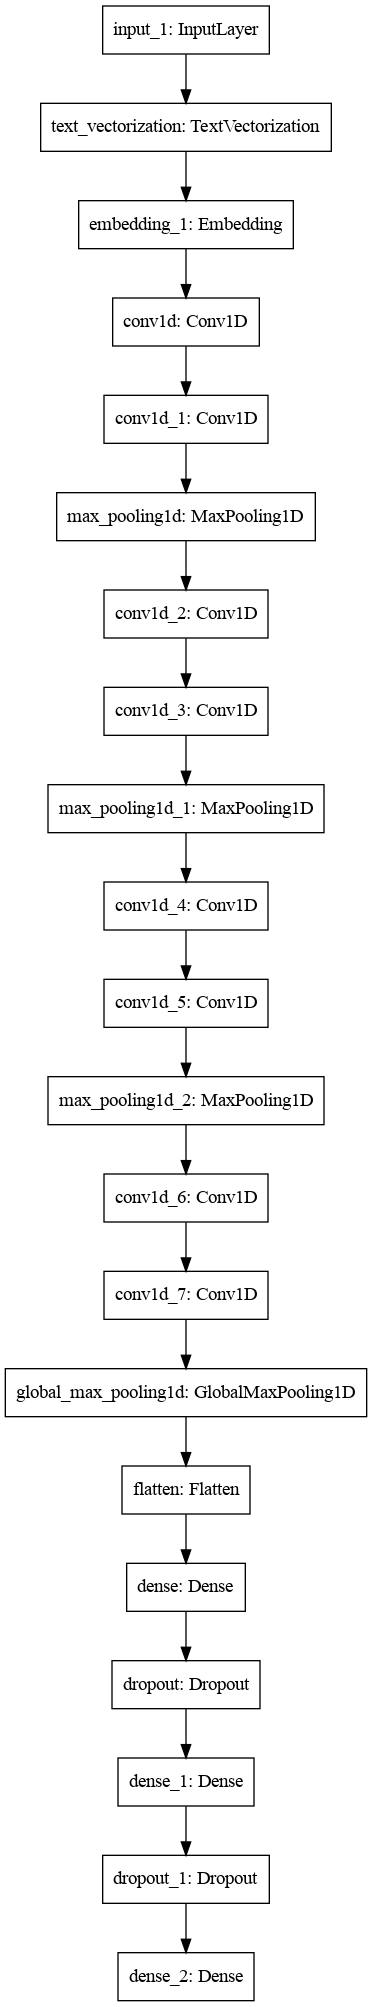

In [36]:
model_CNN.summary()
tf.keras.utils.plot_model(model_CNN, to_file='1D_CNN_model.png')

In [37]:
# Train model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

model_CNN_history = model_CNN.fit(X_train,
                                  Y_train,
                                  batch_size=64,
                                  validation_split=0.15,
                                  epochs=100,
                                  callbacks=[early_stopping_cb])

Epoch 1/100


2021-10-26 23:22:08.475461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-10-26 23:22:08.953034: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


528/528 [==============================] - 17s 26ms/step - loss: 2.0167 - accuracy: 0.3221 - val_loss: 1.7389 - val_accuracy: 0.4084
Epoch 2/100
528/528 [==============================] - 13s 25ms/step - loss: 1.4674 - accuracy: 0.5460 - val_loss: 1.3054 - val_accuracy: 0.6106
Epoch 3/100
528/528 [==============================] - 13s 25ms/step - loss: 1.2009 - accuracy: 0.6339 - val_loss: 1.1113 - val_accuracy: 0.6530
Epoch 4/100
528/528 [==============================] - 13s 25ms/step - loss: 1.0518 - accuracy: 0.6744 - val_loss: 1.1533 - val_accuracy: 0.6648
Epoch 5/100
528/528 [==============================] - 13s 25ms/step - loss: 0.9569 - accuracy: 0.7006 - val_loss: 1.0398 - val_accuracy: 0.6861
Epoch 6/100
528/528 [==============================] - 13s 25ms/step - loss: 0.8801 - accuracy: 0.7271 - val_loss: 0.9989 - val_accuracy: 0.6966
Epoch 7/100
528/528 [==============================] - 13s 25ms/step - loss: 0.8152 - accuracy: 0.7456 - val_loss: 1.0106 - val_accuracy: 0.69

### EVALUATION RESULT

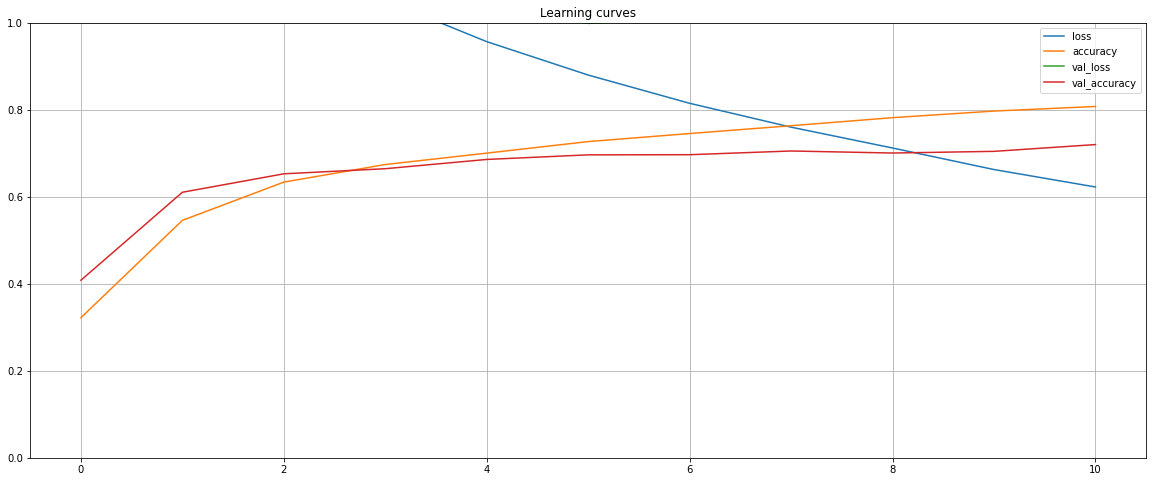

In [38]:
# Learning curves
learning_curves(model_CNN_history)

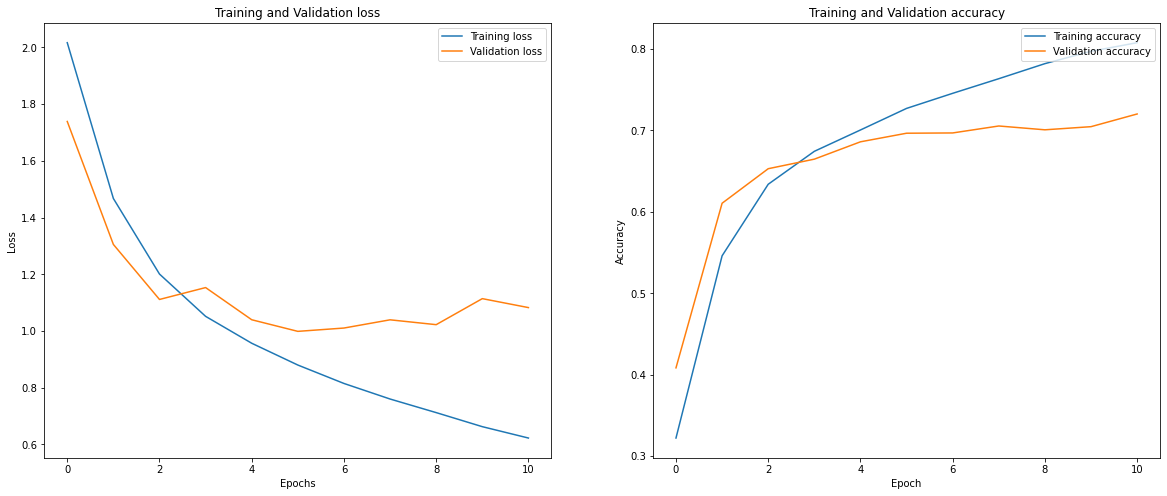

In [39]:
# Evaluation model
evaluation_model(model_CNN_history)

In [40]:
# Check the results
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=num_cuisines)
model_CNN.evaluate(X_test, Y_test)

311/311 [==============================] - 3s 9ms/step - loss: 0.9613 - accuracy: 0.7075


[0.9612715840339661, 0.7074617743492126]

In [41]:
# Predictions
model_CNN_pred_probs = model_CNN.predict(X_test)
model_CNN_pred_probs

array([[5.0733122e-03, 3.4305054e-01, 8.4323529e-03, ..., 9.6288007e-03,
        4.3583586e-04, 1.0773429e-03],
       [3.2468715e-03, 3.1116223e-02, 9.8443411e-02, ..., 6.8148375e-03,
        6.6224740e-05, 2.8096436e-04],
       [4.0581930e-04, 1.0213904e-04, 2.5130638e-03, ..., 2.6848665e-02,
        2.0697573e-04, 1.8240964e-04],
       ...,
       [2.4172673e-03, 6.4948405e-04, 4.6852477e-02, ..., 4.4691119e-02,
        6.1621179e-04, 1.1008645e-03],
       [4.4208570e-04, 1.5750774e-03, 2.1507080e-01, ..., 1.5423493e-03,
        1.5372046e-06, 5.8838805e-06],
       [9.0808686e-07, 1.7137313e-13, 2.2912285e-05, ..., 5.3091590e-05,
        6.0170919e-07, 9.6066526e-07]], dtype=float32)

In [42]:
# Convert pred probs to classes
model_CNN_preds = tf.argmax(model_CNN_pred_probs, axis=1)
model_CNN_preds

<tf.Tensor: shape=(9944,), dtype=int64, numpy=array([ 1, 16,  9, ...,  9, 16, 13])>

In [43]:
test_id = test_df['id']
submission = pd.DataFrame({'id': test_id, 'cuisine': model_CNN_preds}, columns=['id', 'cuisine'])
submission

,id,cuisine
0,18009,1
1,28583,16
2,41580,9
3,29752,2
4,35687,9
...,...,...
9939,30246,5
9940,36028,16
9941,22339,9
9942,42525,16
